## Exploratory Data Analysis


### Unzip data


In [1]:
import zipfile

with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall("data")

### Clean file structure


In [2]:
import os

for label in os.listdir("data/training/training/"):
    os.rename(f"data/training/training/{label}/", f"data/training/{label}/")
os.rmdir("data/training/training")

for label in os.listdir("data/validation/validation/"):
    os.rename(f"data/validation/validation/{label}/", f"data/validation/{label}/")
os.rmdir("data/validation/validation/")

### Clean labels file


In [3]:
import pandas as pd

# Dataset taken from Kaggle: https://www.kaggle.com/datasets/slothkong/10-monkey-species/data
with open("data/monkey_labels.txt", "r") as f:
    labels = f.readlines()
labels = [x.strip() for x in labels]
# Remove tabs, spaces, and empty lines from values
labels = [x.replace(" ", "").replace("\t", "") for x in labels if x]
with open("data/clean_labels.csv", "w") as f:
    f.write("\n".join(labels))

labels = pd.read_csv("data/clean_labels.csv", index_col=0)
labels

,LatinName,CommonName,TrainImages,ValidationImages
Label,,,,
n0,alouatta_palliata,mantled_howler,131,26
n1,erythrocebus_patas,patas_monkey,139,28
n2,cacajao_calvus,bald_uakari,137,27
n3,macaca_fuscata,japanese_macaque,152,30
n4,cebuella_pygmea,pygmy_marmoset,131,26
n5,cebus_capucinus,white_headed_capuchin,141,28
n6,mico_argentatus,silvery_marmoset,132,26
n7,saimiri_sciureus,common_squirrel_monkey,142,28
n8,aotus_nigriceps,black_headed_night_monkey,133,27


### Find and remove duplicates


In [4]:
from imagededup.methods import PHash

phasher = PHash()
encodings = phasher.encode_images(image_dir=f"data/", recursive=True)
duplicates = phasher.find_duplicates_to_remove(encoding_map=encodings)
print(f"\nFound {len(duplicates)} duplicates")

for duplicate in duplicates:
    os.remove(f"data/{duplicate}")

2024-01-10 21:39:07,627: INFO Start: Calculating hashes...
100%|██████████| 1372/1372 [00:16<00:00, 82.30it/s] 
2024-01-10 21:39:26,915: INFO End: Calculating hashes!
c:\Users\Kiyonn\miniconda3\envs\dlor\lib\site-packages\imagededup\methods\hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)
2024-01-10 21:39:26,917: INFO Start: Evaluating hamming distances for getting duplicates
2024-01-10 21:39:26,918: INFO Start: Retrieving duplicates using BKTree algorithm
100%|██████████| 1370/1370 [00:21<00:00, 63.02it/s]
2024-01-10 21:39:51,268: INFO End: Retrieving duplicates using BKTree algorithm
2024-01-10 21:39:51,269: INFO End: Evaluating hamming distances for getting duplicates



Found 173 duplicates


### Train-Val-Test split


In [5]:
from random import shuffle

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.2
# TEST_SPLIT = 0.1

# Get all images in each class
images = dict()
for dir, _, files in os.walk("data"):
    # Skip root and train/val directories
    if dir.count(os.sep) != 2:
        continue

    label = dir.split(os.sep)[-1]
    files = [os.path.join(dir, file) for file in files]
    if label not in images:
        images[label] = files
    else:
        images[label].extend(files)

# Split images in each class randomly into train, val, and test sets
os.mkdir("data/train")
os.mkdir("data/val")
os.mkdir("data/test")
for label in labels.T:
    # Shuffle class images
    imgs = images[label]
    shuffle(imgs)

    # Split into train, val, and test sets
    train_end = int(len(imgs) * TRAIN_SPLIT)
    train_imgs = imgs[:train_end]
    os.mkdir(f"data/train/{label}")
    for img in train_imgs:
        os.rename(img, f"data/train/{label}/{img.split(os.sep)[-1]}")

    os.mkdir(f"data/val/{label}")
    val_end = train_end + int(len(imgs) * VAL_SPLIT)
    val_imgs = imgs[train_end:val_end]
    for img in val_imgs:
        os.rename(img, f"data/val/{label}/{img.split(os.sep)[-1]}")

    os.mkdir(f"data/test/{label}")
    test_imgs = imgs[val_end:]
    for img in test_imgs:
        os.rename(img, f"data/test/{label}/{img.split(os.sep)[-1]}")

    # Remove empty directories
    os.rmdir(f"data/training/{label}")
    os.rmdir(f"data/validation/{label}")

os.rmdir("data/training")
os.rmdir("data/validation")

### Correct number of images for each class


In [6]:
def update_counts(row):
    label = row.name
    row["TrainImages"] = len(os.listdir(f"data/train/{label}"))
    row["ValidationImages"] = len(os.listdir(f"data/val/{label}"))
    row["TestImages"] = len(os.listdir(f"data/test/{label}"))
    return row


labels = labels.apply(update_counts, axis=1)
labels

,LatinName,CommonName,TrainImages,ValidationImages,TestImages
Label,,,,,
n0,alouatta_palliata,mantled_howler,78,22,12
n1,erythrocebus_patas,patas_monkey,86,24,13
n2,cacajao_calvus,bald_uakari,81,23,13
n3,macaca_fuscata,japanese_macaque,101,29,15
n4,cebuella_pygmea,pygmy_marmoset,84,24,13
n5,cebus_capucinus,white_headed_capuchin,85,24,13
n6,mico_argentatus,silvery_marmoset,77,22,11
n7,saimiri_sciureus,common_squirrel_monkey,90,25,14
n8,aotus_nigriceps,black_headed_night_monkey,73,21,11


### Make names prettier for end users


In [7]:
labels["LatinName"] = labels["LatinName"].apply(
    lambda name: name.replace("_", " ").title()
)
labels["CommonName"] = labels["CommonName"].apply(
    lambda name: name.replace("_", " ").title()
)
labels

,LatinName,CommonName,TrainImages,ValidationImages,TestImages
Label,,,,,
n0,Alouatta Palliata,Mantled Howler,78,22,12
n1,Erythrocebus Patas,Patas Monkey,86,24,13
n2,Cacajao Calvus,Bald Uakari,81,23,13
n3,Macaca Fuscata,Japanese Macaque,101,29,15
n4,Cebuella Pygmea,Pygmy Marmoset,84,24,13
n5,Cebus Capucinus,White Headed Capuchin,85,24,13
n6,Mico Argentatus,Silvery Marmoset,77,22,11
n7,Saimiri Sciureus,Common Squirrel Monkey,90,25,14
n8,Aotus Nigriceps,Black Headed Night Monkey,73,21,11


### Save cleaned labels


In [8]:
labels.to_csv("data/clean_labels.csv")

### Print image shapes


In [9]:
import cv2

for i, label in enumerate(labels.T):
    imgs = os.listdir("data/train/" + label)
    for img in imgs[:2]:
        img = cv2.imread("data/train/" + label + "/" + img)
        print(img.shape)

(331, 500, 3)
(816, 1024, 3)
(670, 1000, 3)
(468, 700, 3)
(512, 640, 3)
(395, 640, 3)
(300, 400, 3)
(634, 950, 3)
(908, 1300, 3)
(768, 1024, 3)
(500, 333, 3)
(453, 800, 3)
(2485, 1865, 3)
(870, 1300, 3)
(1050, 700, 3)
(407, 504, 3)
(600, 800, 3)
(682, 1024, 3)
(3456, 2592, 3)
(1709, 3000, 3)


The images are not all the same size and are rather large. They will need to be resized to a smaller size for training.


### Visualise images from each class


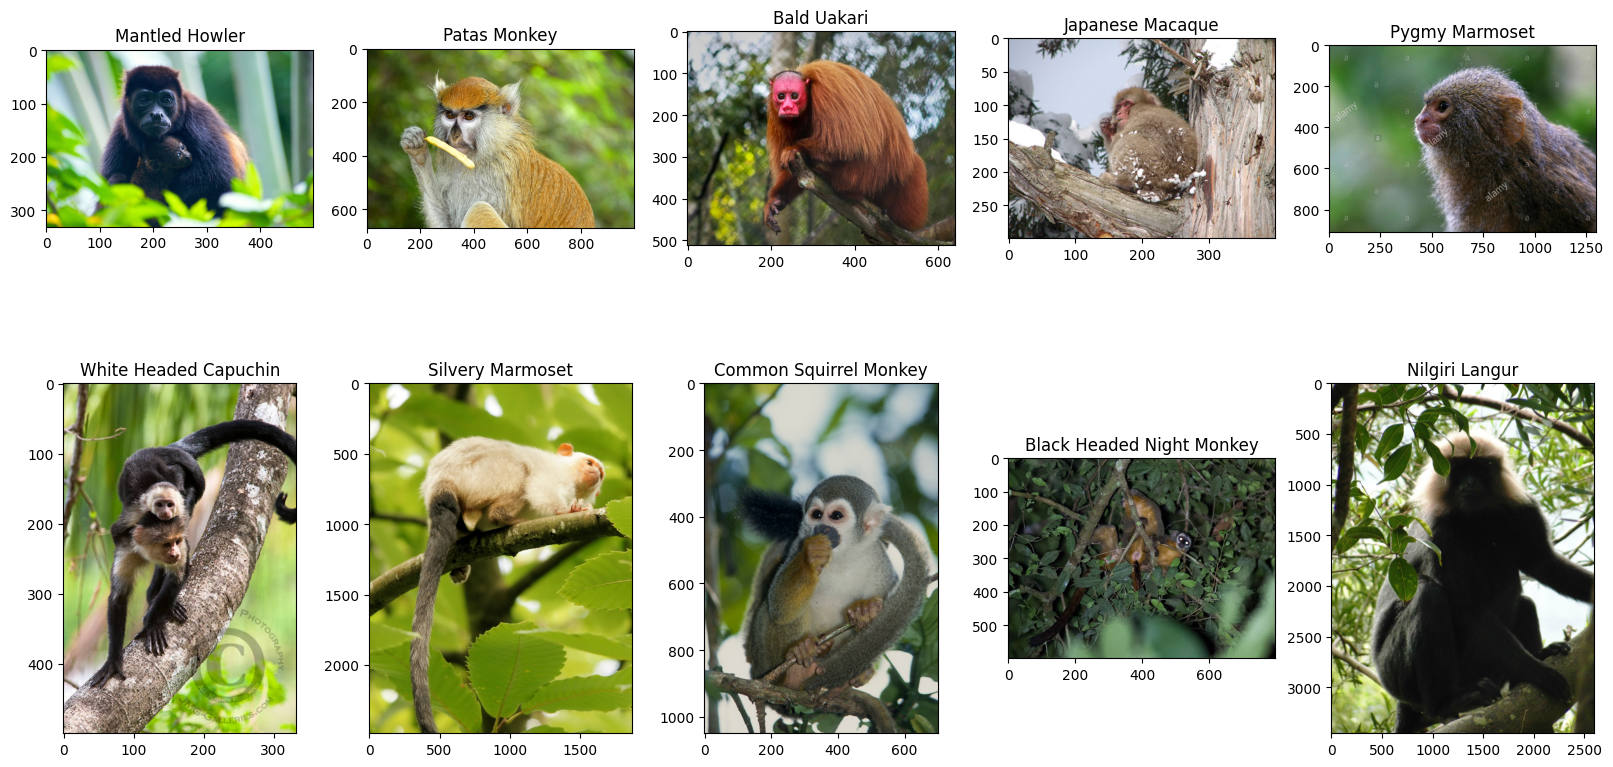

In [10]:
import matplotlib.pyplot as plt

ROWS = 2
COLS = 5
fig, ax = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20, 10))

for i, label in enumerate(labels.T):
    first_img = os.listdir("data/train/" + label)[0]
    img = cv2.imread("data/train/" + label + "/" + first_img)
    # NOTE: Image dataset is in BGR format (take note when deploying model in part 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i // COLS][i % COLS].imshow(img)
    ax[i // COLS][i % COLS].set_title(labels.iloc[i]["CommonName"])

## Data Pre-processing


As the dataset is quite balanced, no oversampling/undersampling is needed.


### Data Augmentaion


In [11]:
from keras.preprocessing.image import ImageDataGenerator

INPUT_SHAPE = (76, 76, 3)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    rescale=1.0 / 255.0,  # Normalise to range [0, 1]
).flow_from_directory(
    "data/train/",
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    shuffle=True,
    interpolation="bicubic",  # A lot of images are resized with bicubic interpolation,
    # so use it in training as well to simulate real-world conditions
)

val_gen = ImageDataGenerator(
    rescale=1.0 / 255.0,
).flow_from_directory(
    "data/val/",
    target_size=INPUT_SHAPE[:2],
    interpolation="bicubic",
)

test_gen = ImageDataGenerator(
    rescale=1.0 / 255.0,
).flow_from_directory(
    "data/test/",
    target_size=INPUT_SHAPE[:2],
    interpolation="bicubic",
)

Found 834 images belonging to 10 classes.
Found 236 images belonging to 10 classes.
Found 127 images belonging to 10 classes.


## Baseline Model


In [12]:
from keras.layers import AveragePooling2D, Conv2D, Dense, Flatten, Dropout
from keras.models import Sequential

model = Sequential(
    [
        # Conv + pool stack 1
        Conv2D(48, (3, 3), activation="leaky_relu", input_shape=INPUT_SHAPE),
        Dropout(0.1),
        Conv2D(48, (3, 3), activation="leaky_relu"),
        Dropout(0.1),
        AveragePooling2D((2, 2)),
        # Conv + pool stack 2
        Conv2D(96, (3, 3), activation="leaky_relu"),
        Dropout(0.1),
        Conv2D(96, (3, 3), activation="leaky_relu"),
        Dropout(0.1),
        AveragePooling2D((2, 2)),
        # Conv + pool stack 3
        Conv2D(192, (3, 3), activation="leaky_relu"),
        Dropout(0.2),
        Conv2D(192, (3, 3), activation="leaky_relu"),
        Dropout(0.2),
        AveragePooling2D((2, 2)),
        # Conv + pool stack 4
        Conv2D(384, (3, 3), activation="leaky_relu"),
        Dropout(0.2),
        Conv2D(384, (3, 3), activation="leaky_relu"),
        Dropout(0.2),
        AveragePooling2D((2, 2)),
        # Classifier
        Flatten(),
        Dense(256, activation="leaky_relu"),
        Dropout(0.3),
        Dense(train_gen.num_classes, activation="softmax"),
    ]
)

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 74, 74, 48)        1344      
                                                                 
 dropout (Dropout)           (None, 74, 74, 48)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 48)        20784     
                                                                 
 dropout_1 (Dropout)         (None, 72, 72, 48)        0         
                                                                 
 average_pooling2d (AverageP  (None, 36, 36, 48)       0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 96)        41568     
                                                        

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["acc"],
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=30, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=5e-5)

history = model.fit(
    train_gen,
    epochs=500,
    callbacks=[early_stopping, reduce_lr],
    validation_data=val_gen,
    workers=4,  # Use 4 CPU cores to reduce the CPU bottleneck from image augmentation
)

Epoch 1/500
27/27 [==============================] - 13s 252ms/step - loss: 2.7569 - acc: 0.1103 - val_loss: 2.3785 - val_acc: 0.1017 - lr: 0.0010
Epoch 2/500
27/27 [==============================] - 7s 244ms/step - loss: 2.3187 - acc: 0.0971 - val_loss: 2.2976 - val_acc: 0.1229 - lr: 0.0010
Epoch 3/500
27/27 [==============================] - 7s 228ms/step - loss: 2.4213 - acc: 0.1007 - val_loss: 2.2982 - val_acc: 0.1229 - lr: 0.0010
Epoch 4/500
27/27 [==============================] - 7s 248ms/step - loss: 2.8086 - acc: 0.1211 - val_loss: 2.2905 - val_acc: 0.1229 - lr: 0.0010
Epoch 5/500
27/27 [==============================] - 7s 254ms/step - loss: 2.3022 - acc: 0.1067 - val_loss: 2.2980 - val_acc: 0.1229 - lr: 0.0010
Epoch 6/500
27/27 [==============================] - 7s 237ms/step - loss: 2.3216 - acc: 0.1151 - val_loss: 2.3012 - val_acc: 0.1059 - lr: 0.0010
Epoch 7/500
27/27 [==============================] - 8s 273ms/step - loss: 2.4053 - acc: 0.1115 - val_loss: 2.6095 - val_ac

### Plot learning curves of baseline model


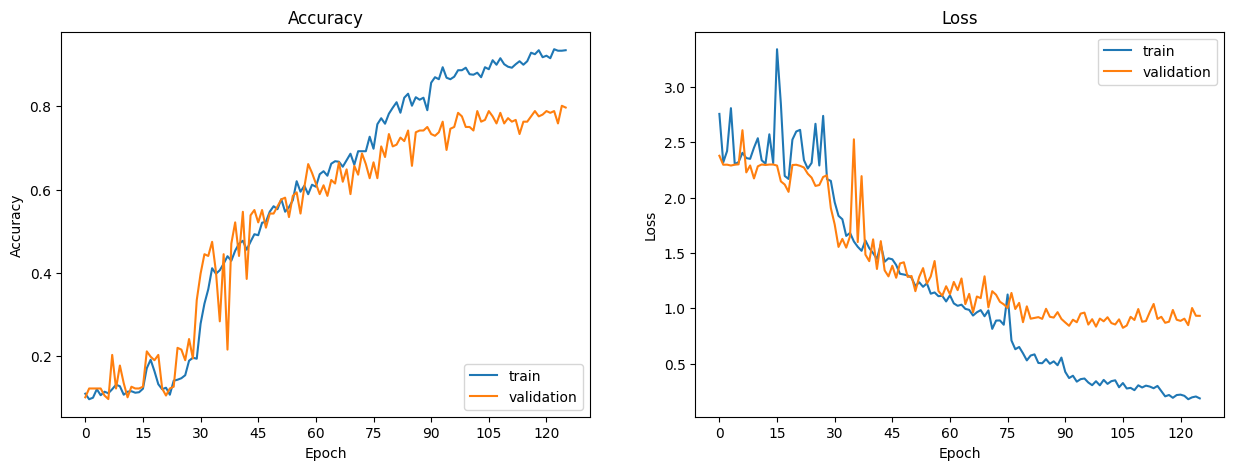

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history["acc"])
ax1.plot(history.history["val_acc"])
ax1.set_title("Accuracy")
ax1.set(xlabel="Epoch", ylabel="Accuracy")
ax1.legend(["train", "validation"], loc="lower right")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(history.history["loss"])
ax2.plot(history.history["val_loss"])
ax2.set_title("Loss")
ax2.set(xlabel="Epoch", ylabel="Loss")
ax2.legend(["train", "validation"], loc="upper right")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [15]:
test_acc = model.evaluate(test_gen, verbose=False)[1]
print(f"Test accuracy of baseline model: {test_acc * 100:.4}%")

Test accuracy of baseline model: 81.89%


## Plans For Improvement


1. Increase model complexity

    The learning curve of the baseline model appears to plateau at around 80% accuracy for the validation set. This suggests that the model is not complex enough to learn the data well, so the most obvious improvement would be to simply add more layers and parameters to the model. Using a complex pre-trained model such as ResNet or Inception would also reduce the training time while improving performance.

2. Use better architecture/layers

    The baseline model uses a very typical CNN architecture, but there are many other ways the model could have been structured. For example, the model could have used fractional pooling or depthwise convolution layers instead of the standard pooling and convolution layers, or had more convolutional layers between each pooling layer.

3. Use a better activation function

    The baseline model uses only leaky ReLU and softmax as its activation functions, but more recently, other activation functions such as Swish and GELU have been shown to possibly perform better (https://towardsdatascience.com/swish-booting-relu-from-the-activation-function-throne-78f87e5ab6eb). A mixture of activation functions could also be used.

4. Use a better optimiser

    The baseline model uses the popular Adam optimiser, but improved versions of Adam such as AdamW have been made and could be used instead.
